In [ ]:
!pip install pysam
!pip install crcmod
!apt-get install samtools

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
### picard
!wget https://github.com/broadinstitute/picard/releases/download/2.21.6/picard.jar

### GATK
!wget -O gatk-4.1.4.1.zip "https://github.com/broadinstitute/gatk/releases/download/4.1.4.1/gatk-4.1.4.1.zip"
!unzip gatk-4.1.4.1.zip
!R -e 'install.packages(c("gplots", "gsalib"))'

In [ ]:
#### downloading HG0096.chr20.sorted bam
!gdown --id 1-0U11U1Z3Dp8vLHoZOtagQl25dFdza-C

In [ ]:
!gsutil ls gs://genomics-public-data

!gsutil ls gs://genomics-public-data/resources/broad/hg38/v0

!wget https://storage.googleapis.com/genomics-public-data/resources/broad/hg38/v0/Homo_sapiens_assembly38.fasta

!git clone https://github.com/lh3/bwa.git
!cd bwa && make

In [ ]:
# Instaliranje rpy2 biblioteke
!pip install rpy2

# Uvoz rpy2 modula
import rpy2.robjects.packages as rpackages
from rpy2.robjects.vectors import StrVector

# Liste paketa
packnames = ['gplots', 'ggplot2', 'gsalib', 'reshape']

# Instalacija paketa
utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind=1)
utils.install_packages(StrVector(packnames))

In [ ]:
!gsutil cp -r gs://genomics-public-data/resources/broad/hg38/v0 .


In [ ]:
!bwa/bwa mem -M -R '@RG\tID:1\tPL:Illumina\tSM:HG00096' -o file.sam {'/content/v0/Homo_sapiens_assembly38.fasta'} {'/content/drive/MyDrive/sample_4.chrom11.exome.pe1.fq'} {'/content/drive/MyDrive/sample_4.chrom11.exome.pe2.fq'}
!samtools view -b -o file.bam file.sam
!samtools sort -o file.sorted.bam file.bam
!samtools index file.sorted.bam

In [8]:
import pysam
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Mapirati sekvencirane readove na referentni genom hg38 upotrebom alata BWA Mem. Upotrebom python biblioteke pysam odrediti sledeće:

2a. Koliko je readova uspešno mapirano?

In [9]:
print('Uspesno je mapirano :')
sum(not read.is_unmapped for read in pysam.AlignmentFile('/content/file.sorted.bam'))

Uspesno je mapirano :


8767682

2b. Koliko je parova readova mapirano tako da su oba para mapirana?

In [10]:
br = 0
for read in pysam.AlignmentFile('/content/file.sorted.bam'):
    if(read.is_proper_pair):
      br += 1
print('Broj readova tako da su oba para mapirana' )
print(br)

Broj readova tako da su oba para mapirana
8621764


In [18]:
print(sum(1 for read in pysam.AlignmentFile('/content/file.sorted.bam').fetch() if read.is_paired and not read.mate_is_unmapped and not read.is_duplicate))

8767573


2c. Nacrtati histogram dužina sekvenciranih fragmenata (template_length).

[ 192  172  247 ...  -19  238 -238]


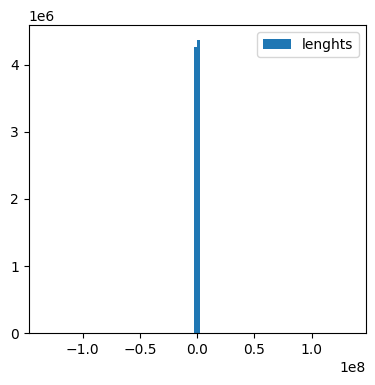

In [57]:
fig = plt.figure(figsize=(20, 4))
ax = fig.add_subplot(1, 4, 1)

bam_file = pysam.AlignmentFile('/content/file.sorted.bam', 'rb')
template_lengths = [record.template_length for record in bam_file.fetch('chr11')]
bam_file.close()
lengths = np.array(template_lengths)
print(lengths)

ax.hist(lengths, label = 'lenghts', bins = 100)
ax.legend()

 Izvršiti obradu dobijenog BAM fajla prema GATK protokolu (Markiranje Duplikata, rekalibracija kvaliteta baza)


Markiranje duplikata

In [ ]:
ibam = 'file.sorted.bam'
obam = 'file.deduped.bam'

!java -jar picard.jar MarkDuplicates I={ibam} O={obam} M=dup_metrics.txt

!grep -A2 '## METRICS CLASS' dup_metrics.txt | grep -v '## METRICS CLASS' > report.tsv

3a. Koliki su procenati PCR i optičkih duplikata?

In [13]:
pd.read_csv('report.tsv', sep='\t')

,LIBRARY,UNPAIRED_READS_EXAMINED,READ_PAIRS_EXAMINED,SECONDARY_OR_SUPPLEMENTARY_RDS,UNMAPPED_READS,UNPAIRED_READ_DUPLICATES,READ_PAIR_DUPLICATES,READ_PAIR_OPTICAL_DUPLICATES,PERCENT_DUPLICATION,ESTIMATED_LIBRARY_SIZE
0,Unknown Library,48390,4351171,16950,257476,36432,561766,0,0.132556,15367092


In [21]:
#broj duplikata je read_pair_duplicates * 2 + unpaired_read_duplicates
# 2 jer su upareni
561766*2 + 36432


1159964

Rekalibracija kvaliteta baza

In [24]:
ibam = '/content/file.deduped.bam'
obam = 'file.recalibrated.bam'
recal = 'file.recal.table'

#baza mutacija
dbsnp = '/content/v0/Homo_sapiens_assembly38.dbsnp138.vcf'
ref = '/content/v0/Homo_sapiens_assembly38.fasta'

gatk = 'java -jar gatk-4.1.4.1/gatk-package-4.1.4.1-local.jar'

In [ ]:
!{gatk} BaseRecalibrator -I {ibam} --known-sites {dbsnp} -O {recal} --reference {ref}

In [ ]:
# pravi novi bam fajl sa prepravljenim kvalitetima baza
!{gatk} ApplyBQSR -I {ibam} -bqsr {recal} -O {obam}


In [ ]:
post_recal = 'file.post_recal.table'
# ovo treba da izgenerise report i opet ga propustamo kroz base recalibrator
!{gatk} BaseRecalibrator -I {obam} --known-sites {dbsnp} -O {post_recal} --reference {ref}


In [30]:
# ovde je sve lepo plotovano i analizirano
!{gatk} AnalyzeCovariates -before {recal} -after {post_recal} -plots 'compare.pdf'

18:48:16.070 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/content/gatk-4.1.4.1/gatk-package-4.1.4.1-local.jar!/com/intel/gkl/native/libgkl_compression.so
18:48:16.682 INFO  AnalyzeCovariates - ------------------------------------------------------------
18:48:16.685 INFO  AnalyzeCovariates - The Genome Analysis Toolkit (GATK) v4.1.4.1
18:48:16.685 INFO  AnalyzeCovariates - For support and documentation go to https://software.broadinstitute.org/gatk/
18:48:16.686 INFO  AnalyzeCovariates - Executing as root@8f3a6fe38d83 on Linux v6.1.85+ amd64
18:48:16.688 INFO  AnalyzeCovariates - Java runtime: OpenJDK 64-Bit Server VM v11.0.23+9-post-Ubuntu-1ubuntu122.04.1
18:48:16.689 INFO  AnalyzeCovariates - Start Date/Time: June 10, 2024 at 6:48:15 PM UTC
18:48:16.689 INFO  AnalyzeCovariates - ------------------------------------------------------------
18:48:16.689 INFO  AnalyzeCovariates - ------------------------------------------------------------
18:48:16.692 INFO  

Identifikovati mutacije upotrebom alata Haplotype Caller i filtirtati mutacije predefinisanim filterima (hard filtering) prema Broad preporukama (kao što je rađeno na vežbama). Prosledimo ref genom i bazu poznatih mutacija -> dbsnp

In [ ]:
gatk = 'java -jar gatk-4.1.4.1/gatk-package-4.1.4.1-local.jar'
dbsnp = '/content/v0/Homo_sapiens_assembly38.dbsnp138.vcf'
ref = '/content/v0/Homo_sapiens_assembly38.fasta'

ibam = '/content/file.recalibrated.bam'
ovcf = 'file.vcf'

!{gatk} HaplotypeCaller --input {ibam} --output {ovcf} --reference {ref} --dbsnp {dbsnp} -L chr11

In [32]:
snp_f = "QD < 2.0 || FS > 60.0 || MQ < 40.0 || MQRankSum < -12.5 || ReadPosRankSum < -8.0"
indel_f = "QD < 2.0 || FS > 200.0 || ReadPosRankSum < -20.0"

ref = '/content/v0/Homo_sapiens_assembly38.fasta'

ivcf = '/content/file.vcf'
isvcf = 'file.snp.vcf'
iivcf = 'file.indel.vcf'


osvcf = 'file.snp.filtered.vcf'
oivcf = 'file.indel.filtered.vcf'
ovcf = 'file.filtered.vcf'

In [ ]:
!{gatk} SelectVariants -R {ref} -V {ivcf} -O {isvcf} --select-type-to-include SNP
!{gatk} VariantFiltration -R {ref} -V {isvcf} -O {osvcf} -filter "{snp_f}" --filter-name "snp"

!{gatk} SelectVariants -R {ref} -V {ivcf} -O {iivcf} --select-type-to-include INDEL
!{gatk} VariantFiltration -R {ref} -V {iivcf} -O {oivcf} -filter "{indel_f}" --filter-name "indel"

!{gatk} MergeVcfs -I {osvcf} -I {oivcf} -O {ovcf}

In [34]:
def is_filtered(variant):
  return 'PASS' not in variant.filter

def is_snp(variant):
  return len(variant.ref) == 1 and len(variant.alts[0]) == 1

def is_transitions(variant):
  allels = set((variant.ref, variant.alts[0]))
  return allels == {'A', 'G'} or allels == {'C', 'T'}

4a. Koliko je ukupno mutacija identifikovano, koliko od njih su SNP-ovi, a koliko INDEL-i?

In [35]:
ovcf = '/content/file.filtered.vcf'

print('SNPs:',
      sum(1 for v in pysam.VariantFile(ovcf) if is_filtered(v) and is_snp(v)))

print('INDELs:',
      sum(1 for v in pysam.VariantFile(ovcf) if is_filtered(v) and not is_snp(v)))

SNPs: 171
INDELs: 26


4b. Koliko mutacija prolazi, a koliko ne prolazi kriterijume filtriranja.

In [36]:
ovcf = '/content/file.filtered.vcf'
print('Filtrirani:', sum(1 for v in pysam.VariantFile(ovcf) if is_filtered(v)))
print('Nefiltrirani:', sum(1 for v in pysam.VariantFile(ovcf) if not is_filtered(v)))

Filtrirani: 197
Nefiltrirani: 5975


4c. Izračunati Ti/Tv odnos pre i posle filtriranja.

In [37]:
x = '/content/file.vcf'

tinF = sum(1 for v in pysam.VariantFile(x) \
         if not is_filtered(v) \
         and is_snp(v)\
         and is_transitions(v))

tvnF = sum(1 for v in pysam.VariantFile(x) \
          if not is_filtered(v) \
          and is_snp(v) \
          and not is_transitions(v))

print('Ti:', tinF)
print('Tv:', tvnF)
print('Ti/Tv odnos pre filtriranja', tinF/tvnF)


tiF = sum(1 for v in pysam.VariantFile(ovcf) \
         if not is_filtered(v) \
         and is_snp(v)\
         and is_transitions(v))

tvF = sum(1 for v in pysam.VariantFile(ovcf) \
          if not is_filtered(v) \
          and is_snp(v) \
          and not is_transitions(v))

print('Ti:', tiF)
print('Tv:', tvF)
print('Ti/Tv odnos posle filtriranja', tiF/tvF)

Ti: 3826
Tv: 1656
Ti/Tv odnos pre filtriranja 2.3103864734299515
Ti: 3710
Tv: 1599
Ti/Tv odnos posle filtriranja 2.320200125078174


Anotirati mutacije alatom Funcotator

In [ ]:
!{gatk} FuncotatorDataSourceDownloader --germline --extract-after-download

In [ ]:
!cp "/content/drive/MyDrive/funcotator-funcotator_dataSources.v1.6.20190124g.tar.gz" .
!tar -xzf "funcotator-funcotator_dataSources.v1.6.20190124g.tar.gz"
ivcf = '/content/file.filtered.vcf'
ovcf = 'file.annotated.vcf'
func = 'funcotator_dataSources.v1.6.20190124g/'

!{gatk} Funcotator -O {ovcf} --ref-version hg38 -R {ref} -V {ivcf} --output-file-format VCF --data-sources-path {func}

In [42]:
reader = pysam.VariantFile(ovcf)
description = reader.header.info['FUNCOTATION'].description
print(description)
functotations = description[73:].split('|')

Functional annotation from the Funcotator tool.  Funcotation fields are: Gencode_27_hugoSymbol|Gencode_27_ncbiBuild|Gencode_27_chromosome|Gencode_27_start|Gencode_27_end|Gencode_27_variantClassification|Gencode_27_secondaryVariantClassification|Gencode_27_variantType|Gencode_27_refAllele|Gencode_27_tumorSeqAllele1|Gencode_27_tumorSeqAllele2|Gencode_27_genomeChange|Gencode_27_annotationTranscript|Gencode_27_transcriptStrand|Gencode_27_transcriptExon|Gencode_27_transcriptPos|Gencode_27_cDnaChange|Gencode_27_codonChange|Gencode_27_proteinChange|Gencode_27_gcContent|Gencode_27_referenceContext|Gencode_27_otherTranscripts|ACMGLMMLof_LOF_Mechanism|ACMGLMMLof_Mode_of_Inheritance|ACMGLMMLof_Notes|ACMG_recommendation_Disease_Name|ClinVar_VCF_AF_ESP|ClinVar_VCF_AF_EXAC|ClinVar_VCF_AF_TGP|ClinVar_VCF_ALLELEID|ClinVar_VCF_CLNDISDB|ClinVar_VCF_CLNDISDBINCL|ClinVar_VCF_CLNDN|ClinVar_VCF_CLNDNINCL|ClinVar_VCF_CLNHGVS|ClinVar_VCF_CLNREVSTAT|ClinVar_VCF_CLNSIG|ClinVar_VCF_CLNSIGCONF|ClinVar_VCF_CLNSIGI

In [ ]:
print('\n'.join(functotations))

5a. Izbrojati različite vrednosti ClinVar značajnosti (anotacija ClinVar_VCF_CLNSIG, koliko mutacija je označeno kao Benign, Likely_benign, itd.).

In [44]:
import io
import pysam

b = 0
lb = 0
b_lb = 0

encodings = ['utf-8', 'latin1', 'cp1252']

for encoding in encodings:
    try:
        with open(ovcf, 'r', encoding=encoding) as vcf_file:
            vcf_wrapper = io.TextIOWrapper(vcf_file, encoding=encoding)
            vcf_reader = pysam.VariantFile(vcf_wrapper)

            for variant in vcf_reader:
                ann = {x: y for x, y in zip(functotations, variant.info['FUNCOTATION'][0][1:-1].split('|'))}

                if ann['ClinVar_VCF_CLNSIG'] == 'Benign':
                    b += 1
                elif ann['ClinVar_VCF_CLNSIG'] == 'Likely_benign':
                    lb += 1
                elif ann['ClinVar_VCF_CLNSIG'] == 'Benign/Likely_benign':
                    b_lb += 1

        break  # Izlazimo iz petlje ako je uspešno otvoren i dekodiran fajl

    except UnicodeDecodeError:
        continue  # Pokušavamo sa sledećim enkodingom ako se javi UnicodeDecodeError

print('Benign:')
print(b)
print('Likely_benign:')
print(lb)
print('Benign/Likely_benign:')
print(b_lb)


Benign:
585
Likely_benign:
42
Benign/Likely_benign:
120


Svi uzorici sadrže određenu količinu kontaminacije DNK materijalom bakterijskog ili virusnog porekla. Većina ovakvih readova se neće mapirati na ljudski genom. Izvući readove koji nisu mapirani u procesu mapiranja, asemblovati ih alatom abyss, i identifikovati organizam od kojeg potiče najduži skafold upotrebom alata Blast.

In [ ]:
!sudo apt-get install autotools-dev automake
!git clone https://github.com/bcgsc/abyss.git
!cd abyss && ./autogen.sh
!cd abyss && ./configure
!cd abyss && make
!cd abyss && sudo make install

!sudo apt-get install abyss

In [ ]:
!wget https://ftp-trace.ncbi.nlm.nih.gov/sra/sdk/2.10.0/setup-apt.sh
!sudo sh setup-apt.sh

In [47]:
# Prazan FASTQ fajl
fastq_file = '/content/drive/MyDrive/novi.fastq'

# Otvaranje fajla u režimu pisanja
with open(fastq_file, 'w') as f:
    pass

# Potvrda završetka
print(f'Prazan FASTQ fajl {fastq_file} je uspešno generisan.')


Prazan FASTQ fajl /content/drive/MyDrive/novi.fastq je uspešno generisan.


In [ ]:
!pip install Bio

In [49]:
from Bio import SeqIO
import pysam
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

In [51]:
from Bio import SeqIO
import pysam

# Putanja do BAM fajla
bam_file = '/content/file.sorted.bam'

# Otvorite BAM fajl za čitanje
bam = pysam.AlignmentFile(bam_file, 'rb')

# Kreirajte praznu listu za čuvanje ne-mapiranih readova
unmapped_reads = []

# Iterirajte kroz svaki read u BAM fajlu
for read in bam.fetch():
    if read.is_unmapped:  # Proverite da li je read ne-mapiran
        unmapped_reads.append(read.query_sequence)

# Zatvorite BAM fajl
bam.close()

# Putanja do izlaznog FASTQ fajla
fastq_file = '/content/drive/MyDrive/novi.fastq'

# Kreiranje i čuvanje FASTQ zapisa za nemapirane readove
seq_records = []
for i, seq in enumerate(unmapped_reads):
    seq_record = SeqRecord(Seq(seq), id=f'read{i+1}', description='')
    seq_record.letter_annotations["phred_quality"] = [40] * len(seq)  # Postavljamo podrazumevanu vrednost kvaliteta
    seq_records.append(seq_record)

SeqIO.write(seq_records, fastq_file, 'fastq')


print(f'FASTQ fajl sa nemapiranim readovima je uspešno kreiran: {fastq_file}')


FASTQ fajl sa nemapiranim readovima je uspešno kreiran: /content/drive/MyDrive/novi.fastq


In [ ]:
!abyss-pe name=chr11 k=64 in='/content/drive/MyDrive/sample_4.chrom11.exome.pe1.fq /content/drive/MyDrive/sample_4.chrom11.exome.pe2.fq'

In [56]:
import pysam

freader = pysam.FastaFile('/content/drive/MyDrive/novi.fastq')

list(zip(freader.lengths, freader.references))

max_ref = sorted(zip(freader.lengths, freader.references), reverse=True)[0]
max_ref

freader.fetch(max_ref[1])

'CTGTAGCTGAAGTAACGCAAGCCATTCAAACCGCTCAGGAACTGAATCTGTCTCTTATACACATCTGACGCTGCCGACGATCTTACGCGTGTAGATCTCGGTGGTCGCCGTATCATTAAAAAAAATGGGGGGGGGGGGGGGGGGGGGGGGG'